In [1]:
import zen
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                #weight = G.weight_(G.edge_idx_(neighbor,node))
                #Ax += np.multiply(centrality[neighbor],weight)

                Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality

def modular_graph(Size1, Size2, edges1, edges2, common, katz_alpha=0.001):
    g1 = zen.generating.barabasi_albert(Size1,edges1)
    avgDeg1 = (2.0 * g1.num_edges)/g1.num_nodes
    lcc1 = np.mean(zen.algorithms.clustering.lcc_(g1))
    
    g2 = zen.generating.barabasi_albert(Size2,edges2)
    avgDeg2 = (2.0 * g2.num_edges)/g2.num_nodes
    lcc2 = np.mean(zen.algorithms.clustering.lcc_(g2))
    
    Size = Size1 + Size2
    G = zen.Graph()
    for i in range(Size):
        G.add_node(i)

    for edge in g1.edges_iter():
        u = edge[0]
        v = edge[1]
        G.add_edge(u,v)

    for edge in g2.edges_iter():
        u = edge[0]+Size1
        v = edge[1]+Size1
        G.add_edge(u,v)

    # Select random pairs of nodes to connect the subgraphs
    join_nodes = np.empty((common,2),dtype=np.int64)
    nodes1 = np.random.randint(0,Size1,size=common)
    nodes2 = np.random.randint(Size1,Size,size=common)
    join_nodes[:,0] = nodes1
    join_nodes[:,1] = nodes2

    for edge in join_nodes:
        if not G.has_edge(edge[0],edge[1]):
            G.add_edge(edge[0],edge[1])
    
    # Modularity Calculation
    classes = {0:np.arange(0,Size1),1:np.arange(Size1,Size)}
    Q = zen.algorithms.modularity(G,classes)

    # Maximum Modularity
    count=0.0
    for e in G.edges():
        if (e[0]<Size1 and e[1]<Size1) or (e[0]>=Size1 and e[1]>=Size1):
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    q_norm = Q/qmax
    
    evc = zen.algorithms.eigenvector_centrality_(G)
    kc = katz(G,alpha=katz_alpha)
    
    return avgDeg1, avgDeg2, lcc1, lcc2, q_norm, evc, kc

In [4]:
size1 = 300
size2 = 250
edge1 = 10
edge2 = 20
common_edges= 800
avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)

In [5]:
print "                     G1     |  G2"
print "Average Degree:      %.2f   |  %.2f"%(avgDeg1,avgDeg2)
print "Avgerage Clustering: %.2f   |  %.2f"%(avgLcc1,avgLcc2)
print ""
print "Modularity: %.2f"%mod

                     G1     |  G2
Average Degree:      19.33   |  36.80
Avgerage Clustering: 0.14   |  0.24

Modularity: 0.80


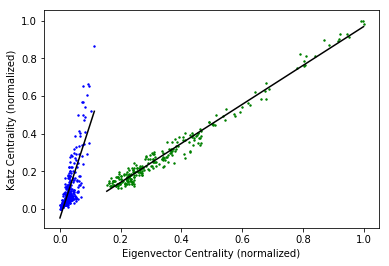

32.714 degrees between lines
median green evc: 0.28


In [6]:
evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

evc1 = evc[np.arange(size1)]
evc2 = evc[np.arange(size2)+size1]
kc1 = kc[np.arange(size1)]
kc2 = kc[np.arange(size2)+size1]

m1, b1, _,_,_ = linregress(evc1,kc1)
m2,b2,_,_,_ = linregress(evc2,kc2)

xx1 = np.linspace(np.min(evc1),np.max(evc1),2)
xx2 = np.linspace(np.min(evc2),np.max(evc2),2)
yy1 = m1*xx1 + b1
yy2 = m2*xx2 + b2
plt.scatter(evc1,kc1,s=2,c='b')
plt.plot(xx1,yy1,c='k')
plt.scatter(evc2,kc2,s=2,c='g')
plt.plot(xx2,yy2,c='k')
plt.xlabel('Eigenvector Centrality (normalized)')
plt.ylabel('Katz Centrality (normalized)')
plt.show()
print "%.3f degrees between lines"%(np.abs(np.arctan(m1) - np.arctan(m2))*180/np.pi)
print "median green evc: %.2f"%(np.median(evc2))

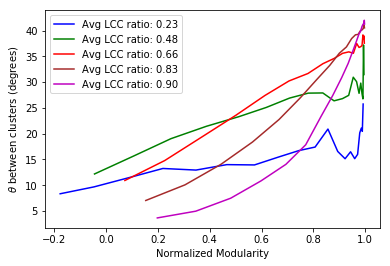

CPU times: user 2min 51s, sys: 244 ms, total: 2min 52s
Wall time: 2min 51s


In [547]:
%%time
SAMPLES=10

size1 = 250
size2 = 250

edge2 = 20
colors = ['b','g','r','brown','m']
for j,edge1 in enumerate([3,6,10,14,17]):
    modu = np.empty((SAMPLES,20))
    angle = np.empty((SAMPLES,20))
    for i in range(SAMPLES):
        modularity = []
        angle_diff = []
        for common_edges in np.logspace(1,np.log10(6000),20,dtype=int):
            avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            modularity.append(mod)
            ratio = avgLcc1 / avgLcc2
            evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
            kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

            evc1 = evc[np.arange(size1)]
            evc2 = evc[np.arange(size2)+size1]
            kc1 = kc[np.arange(size1)]
            kc2 = kc[np.arange(size2)+size1]


            m1, b1, _,_,_ = linregress(evc1,kc1)
            m2,b2,_,_,_ = linregress(evc2,kc2)

            theta1 = np.arctan(m1)
            theta2 = np.arctan(m2)

            diff = np.abs(theta1-theta2)
            angle_diff.append(diff* (180 / np.pi))
        modu[i,:] = modularity
        angle[i,:] = angle_diff

    plt.plot(np.mean(modu,axis=0),np.mean(angle,axis=0),c=colors[j],label='Avg LCC ratio: %.2f'%(ratio))

plt.legend()
plt.xlabel('Normalized Modularity')
plt.ylabel(r'$\theta$ between clusters (degrees)')
plt.show()

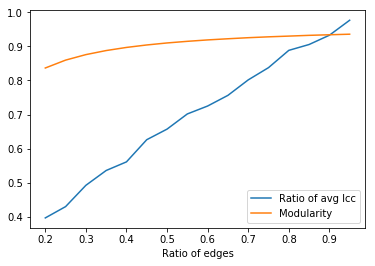

In [616]:
SAMPLE = 10
modu = np.empty((SAMPLE,16))
lcc = np.empty((SAMPLE,16))
edges = np.arange(4,20)
size1 = 250
size2 = 250
#edge1 = 6
edge2 = 20
common_edges = 300
for i in range(SAMPLE):
    modularity = []
    angle_diff = []
    lcc_ratio = []
    for edge1 in edges:
        avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
        modularity.append(mod)
        ratio = avgLcc1 / avgLcc2
        lcc_ratio.append(ratio)
    modu[i,:] = modularity
    lcc[i,:] = lcc_ratio

plt.plot(edges/float(edge2),np.mean(lcc,axis=0),label='Ratio of avg lcc')
plt.plot(edges/float(edge2),np.mean(modu,axis=0),label='Modularity')
plt.xlabel('Ratio of edges')
plt.legend()
plt.show()

VBox(children=(HTML(value=u''), IntProgress(value=0, max=1000)))

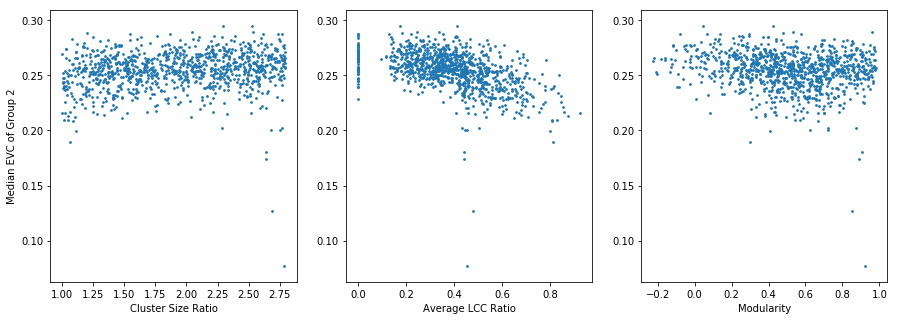

CPU times: user 3min 47s, sys: 792 ms, total: 3min 48s
Wall time: 3min 47s


In [544]:
%%time
med = []
size_ratio = []
lcc_ratio = []
modularity = []
for _ in log_progress(range(1000),every=10):
    size1 = np.random.randint(250,700)
    size2 = 250
    edge1 = np.random.randint(1,17)
    edge2 = 20
    common_edges= np.random.randint(100,5000)
    
    avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
    
    evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
    evc1 = evc[np.arange(size1)]
    evc2 = evc[np.arange(size2)+size1]
    med.append(np.median(evc2))
    size_ratio.append(float(size1)/size2)
    lcc_ratio.append(avgLcc1/avgLcc2)
    modularity.append(mod)
    
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(size_ratio,med,s=3)
ax[0].set_xlabel('Cluster Size Ratio')
ax[0].set_ylabel('Median EVC of Group 2')

ax[1].scatter(lcc_ratio, med,s=3)
ax[1].set_xlabel('Average LCC Ratio')
#ax[1].set_ylabel('Median EVC of Group 2')

ax[2].scatter(modularity, med,s=3)
ax[2].set_xlabel('Modularity')
#ax[2].set_ylabel('Median EVC of Group 2')

plt.show()

VBox(children=(HTML(value=u''), IntProgress(value=0, max=1000)))

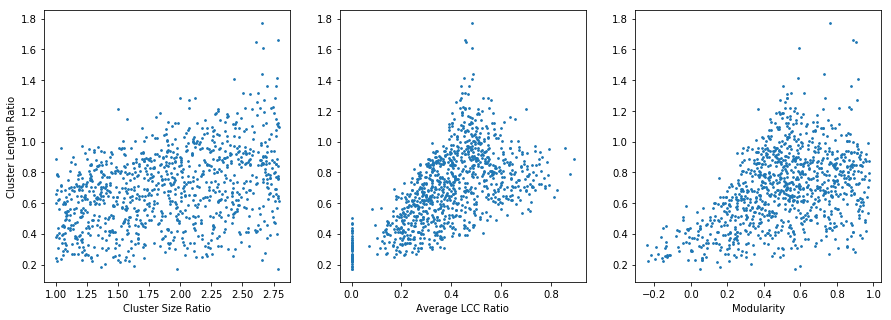

CPU times: user 3min 48s, sys: 828 ms, total: 3min 49s
Wall time: 3min 48s


In [546]:
%%time
length_ratio = []
size_ratio = []
lcc_ratio = []
modularity = []
for _ in log_progress(range(1000),every=10):
    size1 = np.random.randint(250,700)
    size2 = 250
    edge1 = np.random.randint(1,17)
    edge2 = 20
    common_edges= np.random.randint(100,5000)
    
    avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)

    evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
    kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

    evc1 = evc[np.arange(size1)]
    evc2 = evc[np.arange(size2)+size1]
    kc1 = kc[np.arange(size1)]
    kc2 = kc[np.arange(size2)+size1]
    
    dist1 = np.linalg.norm([np.max(evc1)-np.min(evc1),np.max(kc1)-np.min(kc1)])
    dist2 = np.linalg.norm([np.max(evc2)-np.min(evc2),np.max(kc2)-np.min(kc2)])
    
    length_ratio.append(dist1/dist2)
    size_ratio.append(float(size1)/size2)
    lcc_ratio.append(avgLcc1/avgLcc2)
    modularity.append(mod)
    
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(size_ratio,length_ratio,s=3)
ax[0].set_xlabel('Cluster Size Ratio')
ax[0].set_ylabel('Cluster Length Ratio')

ax[1].scatter(lcc_ratio, length_ratio,s=3)
ax[1].set_xlabel('Average LCC Ratio')
#ax[1].set_ylabel('Cluster Length Ratio')

ax[2].scatter(modularity, length_ratio,s=3)
ax[2].set_xlabel('Modularity')
#ax[2].set_ylabel('Cluster Length Ratio')

plt.show()

VBox(children=(HTML(value=u''), IntProgress(value=0, max=5)))

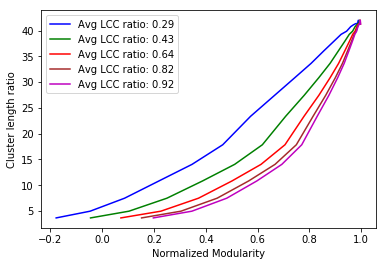

CPU times: user 5min 33s, sys: 580 ms, total: 5min 33s
Wall time: 5min 33s


In [643]:
%%time
SAMPLES=20

size1 = 250
size2 = 250

edge2 = 20
colors = ['b','g','r','brown','m']
j=-1
for edge1 in log_progress([3,6,10,14,17]):
    j+=1
    modu = np.empty((SAMPLES,20))
    length_rat = np.empty((SAMPLES,20))
    for i in range(SAMPLES):
        modularity = []
        length_ratio = []
        for common_edges in np.logspace(1,np.log10(6000),20,dtype=int):
            avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            modularity.append(mod)
            ratio = avgLcc1 / avgLcc2
            evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
            kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

            evc1 = evc[np.arange(size1)]
            evc2 = evc[np.arange(size2)+size1]
            kc1 = kc[np.arange(size1)]
            kc2 = kc[np.arange(size2)+size1]

            dist1 = np.linalg.norm([np.max(evc1)-np.min(evc1),np.max(kc1)-np.min(kc1)])
            dist2 = np.linalg.norm([np.max(evc2)-np.min(evc2),np.max(kc2)-np.min(kc2)])

            length_ratio.append(dist1/dist2)
        modu[i,:] = modularity
        length_rat[i,:] = length_ratio
    plt.plot(np.mean(modu,axis=0),np.mean(angle,axis=0),c=colors[j],label='Avg LCC ratio: %.2f'%(ratio))

plt.legend()
plt.xlabel('Normalized Modularity')
plt.ylabel('Cluster length ratio')
plt.show()

In [8]:
def getCentroids(dfC1,dfC2):
    normedC1 = dfC1[['Katz','EVC']].apply(np.linalg.norm,axis=1)
    normedC2 = dfC2[['Katz','EVC']].apply(np.linalg.norm,axis=1)
    med1 = np.median(normedC1)
    med2 = np.median(normedC2)
    c1_centroid_idx = normedC1[normedC1<med1].index.values
    c2_centroid_idx = normedC2[normedC2<med2].index.values
    c1_centroid = dfC1.loc[c1_centroid_idx,:].mean().values
    c2_centroid = dfC2.loc[c2_centroid_idx,:].mean().values
    return c1_centroid, c2_centroid

VBox(children=(HTML(value=u''), IntProgress(value=0, max=1000)))

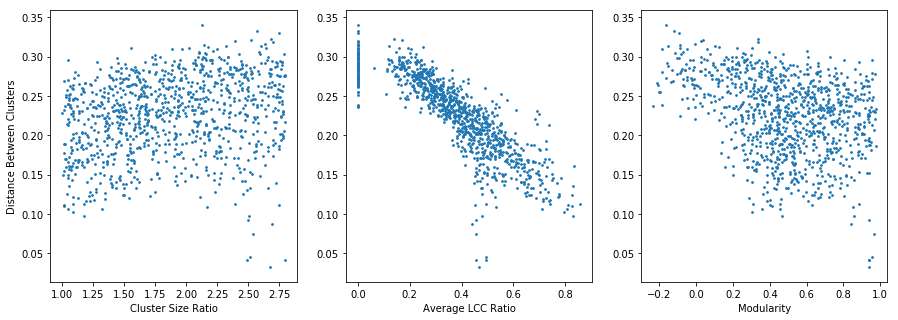

CPU times: user 4min 5s, sys: 932 ms, total: 4min 6s
Wall time: 4min 5s


In [640]:
%%time
centroid_distance = []
size_ratio = []
lcc_ratio = []
modularity = []
for _ in log_progress(range(1000),every=10):
    size1 = np.random.randint(250,700)
    size2 = 250
    edge1 = np.random.randint(1,17)
    edge2 = 20
    common_edges= np.random.randint(100,5000)
    avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)

    evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
    kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

    evc1 = evc[np.arange(size1)]
    evc2 = evc[np.arange(size2)+size1]
    kc1 = kc[np.arange(size1)]
    kc2 = kc[np.arange(size2)+size1]

    dfC1 = pd.DataFrame({'Katz':kc1,'EVC':evc1})
    dfC2 = pd.DataFrame({'Katz':kc2,'EVC':evc2})
    c1_centroid, c2_centroid = getCentroids(dfC1,dfC2)
    distance = np.linalg.norm(c1_centroid - c2_centroid)
    centroid_distance.append(distance)
    size_ratio.append(float(size1)/size2)
    lcc_ratio.append(avgLcc1/avgLcc2)
    modularity.append(mod)

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(size_ratio,centroid_distance,s=3)
ax[0].set_xlabel('Cluster Size Ratio')
ax[0].set_ylabel('Distance Between Clusters')

ax[1].scatter(lcc_ratio, centroid_distance,s=3)
ax[1].set_xlabel('Average LCC Ratio')
#ax[1].set_ylabel('Cluster Length Ratio')

ax[2].scatter(modularity, centroid_distance,s=3)
ax[2].set_xlabel('Modularity')
#ax[2].set_ylabel('Cluster Length Ratio')

plt.show()

VBox(children=(HTML(value=u''), IntProgress(value=0, max=5)))

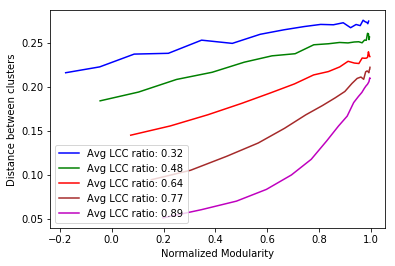

CPU times: user 6min 29s, sys: 1.37 s, total: 6min 30s
Wall time: 6min 29s


In [9]:
%%time
SAMPLES=20

size1 = 250
size2 = 250

edge2 = 20
colors = ['b','g','r','brown','m']
j=-1
for edge1 in log_progress([3,6,10,14,17]):
    j+=1
    modu = np.empty((SAMPLES,20))
    dist = np.empty((SAMPLES,20))
    for i in range(SAMPLES):
        modularity = []
        dist_ = []
        for common_edges in np.logspace(1,np.log10(6000),20,dtype=int):
            avgDeg1, avgDeg2, avgLcc1, avgLcc2, mod, evc, kc = modular_graph(size1, size2, edge1, edge2, common_edges)
            modularity.append(mod)
            ratio = avgLcc1 / avgLcc2
            evc = (evc - np.min(evc)) / np.max(evc - np.min(evc))
            kc = (kc - np.min(kc)) / np.max(kc - np.min(kc))

            evc1 = evc[np.arange(size1)]
            evc2 = evc[np.arange(size2)+size1]
            kc1 = kc[np.arange(size1)]
            kc2 = kc[np.arange(size2)+size1]

            dfC1 = pd.DataFrame({'Katz':kc1,'EVC':evc1})
            dfC2 = pd.DataFrame({'Katz':kc2,'EVC':evc2})
            c1_centroid, c2_centroid = getCentroids(dfC1,dfC2)
            distance = np.linalg.norm(c1_centroid - c2_centroid)
            dist_.append(distance)
            
        modu[i,:] = modularity
        dist[i,:] = dist_

    plt.plot(np.mean(modu,axis=0),np.mean(dist,axis=0),c=colors[j],label='Avg LCC ratio: %.2f'%(ratio))

plt.legend()
plt.xlabel('Normalized Modularity')
plt.ylabel('Distance between clusters')
plt.show()